# Introduction

The following notebook presents both the definition of the models to be used (including preprocessing and hyperparameter tuning) and their respective evaluation.

# 0. Import Libraries and Other Code

In [1]:
# Relevant Libraries

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

import seaborn as sns
import matplotlib.pyplot as plt

import os

# 1. Load and Split Dataset

In [2]:
# Loading dataset

PlantGrowth_Dataset = pd.read_csv("../Datasets/plant_growth_data.csv")

# Splitting variables into Numerical and Categorical Features and Target

labels_variables = PlantGrowth_Dataset.columns

Features = labels_variables[:-1]
Target = labels_variables[-1]

NumericalFeatures , CategoricalFeatures = [] , []
for feature in Features:
    if PlantGrowth_Dataset[feature].dtype == 'object':
        CategoricalFeatures.append(feature)
    else:
        NumericalFeatures.append(feature)

In [3]:
# Splitting dataset

RANDOM_STATE = 8013

X_train , X_test , y_train , y_test = train_test_split(PlantGrowth_Dataset[Features],PlantGrowth_Dataset[Target],test_size=0.25,random_state=RANDOM_STATE)

# 2. Preprocessing Pipeline

As it could be observed in the EDA of the dataset, the numerical features are not separated or distinguished according to the significant growth reported, therefore it is proposed to generate features that are obtained from them in a simple way, that is, by applying non-linear functions such as: ``sqrt``, ``log10``, ``1/x`` and ``x**2``, together with the identity function. In order to promote other types of interactions or relationships.

In the case of the categorical features, since the only relevant feature is ``Fertilizer_Type`` and the other two seem to be independent for predicting the type of growth, they are kept in case of possible interactions with the other numerical features.

After generating the different features, it can be concluded that the attribute space is large, this is negative for the training of the model, since it increases the computational cost and possible redundancies; therefore, to reduce this impact, attribute selection is used. For numerical features, it is used mutual information (to be able to capture non-linear relationships and interactions), and for categorical features, it is used $\chi^2$ (to consider features that are not independent with respect to ``Growth_Milestone``).

In [4]:
# Importing additional estimators

from sklearn.preprocessing import OneHotEncoder , StandardScaler , FunctionTransformer
from sklearn.feature_selection import SelectKBest , mutual_info_classif , chi2

In [5]:
# Defining Numerical Preprocessing

extras_numerical_features = FeatureUnion(
    [
        ('x',FunctionTransformer(lambda x: x)),
        ('1/x',FunctionTransformer(lambda x: 1/x)),
        ('x**2',FunctionTransformer(lambda x: x*x)),
        ('sqrt',FunctionTransformer(np.sqrt)),
        ('log10',FunctionTransformer(np.log10)),
    ]
)

numerical_preprocessing = Pipeline(
    [
        ('ExtraFeatures',extras_numerical_features),
        ('Standardization',StandardScaler()),
        ('FeatureSelection',SelectKBest(mutual_info_classif,k=5)),
    ]
)

numerical_preprocessing

Pipeline(steps=[('ExtraFeatures',
                 FeatureUnion(transformer_list=[('x',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002002FFCF600>)),
                                                ('1/x',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002002FFCEDE0>)),
                                                ('x**2',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002002FFECCC0>)),
                                                ('sqrt',
                                                 FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                ('log10',
                                                 FunctionTransformer(func=<ufunc 'log10'>))])),
                ('Standardization', StandardScaler()),
                ('FeatureSelection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x000002002FFCDC60>))])

In [6]:
# Defining Categorical Preprocessing

categorical_preprocessing = Pipeline(
    [
        ('Encode',OneHotEncoder()),
        ('FeatureSelection',SelectKBest(chi2,k=5)),
    ]
)

categorical_preprocessing

Pipeline(steps=[('Encode', OneHotEncoder()),
                ('FeatureSelection',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x000002002FFCF740>))])

In [7]:
# Defining Features Preprocessing

Features_Preprocessing = ColumnTransformer(
    [
        ('CategoricalFeatures',categorical_preprocessing,CategoricalFeatures),
        ('NumericalFeatures',numerical_preprocessing,NumericalFeatures),
    ]
)

Features_Preprocessing

ColumnTransformer(transformers=[('CategoricalFeatures',
                                 Pipeline(steps=[('Encode', OneHotEncoder()),
                                                 ('FeatureSelection',
                                                  SelectKBest(k=5,
                                                              score_func=<function chi2 at 0x000002002FFCF740>))]),
                                 ['Soil_Type', 'Water_Frequency',
                                  'Fertilizer_Type']),
                                ('NumericalFeatures',
                                 Pipeline(steps=[('ExtraFeatures',
                                                  FeatureUnion(transformer_list=[('x',
                                                                                  FunctionTransformer(func=...
                                                                                  FunctionTransformer(func=<function <lambda> at 0x000002002FFECCC0>)),
                                                                                 ('sqrt',
                                                                                  FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                 ('log10',
                                                                                  FunctionTransformer(func=<ufunc 'log10'>))])),
                                                 ('Standardization',
                                                  StandardScaler()),
                                                 ('FeatureSelection',
                                                  SelectKBest(k=5,
                                                              score_func=<function mutual_info_classif at 0x000002002FFCDC60>))]),
                                 ['Sunlight_Hours', 'Temperature',
                                  'Humidity'])])

In [8]:
# Defining Preprocessing Pipeline

Preprocessing_Pipeline = Pipeline(
    [
        ('FeaturesPreprocessing',Features_Preprocessing),
    ]
)

Preprocessing_Pipeline

Pipeline(steps=[('FeaturesPreprocessing',
                 ColumnTransformer(transformers=[('CategoricalFeatures',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder()),
                                                                  ('FeatureSelection',
                                                                   SelectKBest(k=5,
                                                                               score_func=<function chi2 at 0x000002002FFCF740>))]),
                                                  ['Soil_Type',
                                                   'Water_Frequency',
                                                   'Fertilizer_Type']),
                                                 ('NumericalFeatures',
                                                  Pipeline(steps=[('ExtraFeatures',
                                                                   FeatureUnion(transfo...
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x000002002FFECCC0>)),
                                                                                                  ('sqrt',
                                                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                  ('log10',
                                                                                                   FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                  ('Standardization',
                                                                   StandardScaler()),
                                                                  ('FeatureSelection',
                                                                   SelectKBest(k=5,
                                                                               score_func=<function mutual_info_classif at 0x000002002FFCDC60>))]),
                                                  ['Sunlight_Hours',
                                                   'Temperature',
                                                   'Humidity'])]))])

# 3. Model Architectures

Due to what can be seen in the EDA, the classes for the significant growth type are not linearly separable, that is, they do not have decision edges that arise from linear functions; therefore, it is necessary to generate this separation by means of models that use or create nonlinear decision edges.

Therefore, it is considered to use models based on Support Vector Machine, Random Forest and Adaptive Boost (AdaBoost) [[1]](#references) to define the classifier.

In [9]:
# Importing models

from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

In [10]:
# Model Architectures 

Model_Architectures = ['SVM','Forest','AdaBoost']

# Defining number of threads or n_jobs 

THREADS = int(np.sqrt(os.cpu_count()))

## 3.1 Support Vector Machine

In [11]:
# SVM model

Model_SVM = Pipeline(
    [
        ('Preprocessing',Preprocessing_Pipeline),
        ('Classifier',SVC(random_state=RANDOM_STATE)),
    ]
)

c_parameters = np.linspace(0.1,2,20)
Parameters_SVM = [
    {
        'Classifier__kernel' : ['poly'],
        'Classifier__degree' : [1,2,3],
        'Classifier__coef0' : [0,0.5,1],
        'Classifier__C' : c_parameters,
        'Classifier__shrinking' : [False,True],
    },
    {
        'Classifier__kernel' : ['rbf'],
        'Classifier__gamma' : ['scale','auto'],
        'Classifier__C' : c_parameters,
        'Classifier__shrinking' : [False,True],
    },
    {
        'Classifier__kernel' : ['sigmoid'],
        'Classifier__gamma' : ['scale','auto'],
        'Classifier__C' : c_parameters,
        'Classifier__shrinking' : [False,True],
    }
]

Model_SVM

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('FeaturesPreprocessing',
                                  ColumnTransformer(transformers=[('CategoricalFeatures',
                                                                   Pipeline(steps=[('Encode',
                                                                                    OneHotEncoder()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=5,
                                                                                                score_func=<function chi2 at 0x000002002FFCF740>))]),
                                                                   ['Soil_Type',
                                                                    'Water_Frequency',
                                                                    'Fertilizer_Type']),
                                                                  ('NumericalFeatures',
                                                                   Pipeline(steps=[('Ex...
                                                                                                                    FunctionTransformer(func=<function <lambda> at 0x000002002FFECCC0>)),
                                                                                                                   ('sqrt',
                                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                                   ('log10',
                                                                                                                    FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                                   ('Standardization',
                                                                                    StandardScaler()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=5,
                                                                                                score_func=<function mutual_info_classif at 0x000002002FFCDC60>))]),
                                                                   ['Sunlight_Hours',
                                                                    'Temperature',
                                                                    'Humidity'])]))])),
                ('Classifier', SVC(random_state=8013))])

## 3.2 Random Forest

In [12]:
# Random Forest model

Model_Forest = Pipeline(
    [
        ('Preprocessing',Preprocessing_Pipeline),
        ('Classifier',RandomForestClassifier(random_state=RANDOM_STATE,n_jobs=THREADS)),
    ]
)

estimators_parameter = np.linspace(25,150,6,dtype=int)
Parameters_Forest = {
    'Classifier__n_estimators' : estimators_parameter,
    'Classifier__criterion' : ['gini','entropy'],
    'Classifier__max_depth' : range(1,11),
}

Model_Forest

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('FeaturesPreprocessing',
                                  ColumnTransformer(transformers=[('CategoricalFeatures',
                                                                   Pipeline(steps=[('Encode',
                                                                                    OneHotEncoder()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=5,
                                                                                                score_func=<function chi2 at 0x000002002FFCF740>))]),
                                                                   ['Soil_Type',
                                                                    'Water_Frequency',
                                                                    'Fertilizer_Type']),
                                                                  ('NumericalFeatures',
                                                                   Pipeline(steps=[('Ex...
                                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                                   ('log10',
                                                                                                                    FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                                   ('Standardization',
                                                                                    StandardScaler()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=5,
                                                                                                score_func=<function mutual_info_classif at 0x000002002FFCDC60>))]),
                                                                   ['Sunlight_Hours',
                                                                    'Temperature',
                                                                    'Humidity'])]))])),
                ('Classifier',
                 RandomForestClassifier(n_jobs=4, random_state=8013))])

## 3.3 Adaptive Boosting

In [13]:
# AdaBoost model

Model_AdaBoost = Pipeline(
    [
        ('Preprocessing',Preprocessing_Pipeline),
        ('Classifier',AdaBoostClassifier(random_state=RANDOM_STATE,algorithm='SAMME')),
    ]
)

Parameters_AdaBoost = {
    'Classifier__estimator' : [DecisionTreeClassifier(max_depth=depth,random_state=RANDOM_STATE) for depth in range(1,6)],
    'Classifier__n_estimators' : np.linspace(25,150,6,dtype=int),
}

Model_AdaBoost

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('FeaturesPreprocessing',
                                  ColumnTransformer(transformers=[('CategoricalFeatures',
                                                                   Pipeline(steps=[('Encode',
                                                                                    OneHotEncoder()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=5,
                                                                                                score_func=<function chi2 at 0x000002002FFCF740>))]),
                                                                   ['Soil_Type',
                                                                    'Water_Frequency',
                                                                    'Fertilizer_Type']),
                                                                  ('NumericalFeatures',
                                                                   Pipeline(steps=[('Ex...
                                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                                   ('log10',
                                                                                                                    FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                                   ('Standardization',
                                                                                    StandardScaler()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=5,
                                                                                                score_func=<function mutual_info_classif at 0x000002002FFCDC60>))]),
                                                                   ['Sunlight_Hours',
                                                                    'Temperature',
                                                                    'Humidity'])]))])),
                ('Classifier',
                 AdaBoostClassifier(algorithm='SAMME', random_state=8013))])

# 4. Models Fine-Tunning

What is sought is not to overestimate the growth of a plant, that is, not to indicate that a plant will grow efficiently when it does not. In other words, the aim is to reduce false positives, so the metric considered for the fine-tunning of hyperparameters of the models is ``precision``.

For fine-tunning the hyper-parameters of the model architectures, Cross-Validation with $6$ folds is used (this is to give a balance between training and testing instances).

In [14]:
# Global variables
Global_Variables = globals()

In [17]:
# Fine-Tunning using Cross-Validation
folds_k = 6

for model_name in Model_Architectures:
    estimator_model = Global_Variables[f'Model_{model_name}']
    parameters_model = Global_Variables[f'Parameters_{model_name}']

    Global_Variables[f'Best_{model_name}'] = GridSearchCV(estimator_model,parameters_model,scoring='precision',cv=folds_k,n_jobs=THREADS)
    Global_Variables[f'Best_{model_name}'].fit(X_train,y_train)

In [18]:
# Printing of best parameters for each model

for model_name in Model_Architectures:
    best_parameters = Global_Variables[f'Best_{model_name}'].best_params_
    print(f'Best found parameters of {model_name} are:\n{best_parameters}\n')

Best found parameters of SVM are:
{'Classifier__C': np.float64(0.4), 'Classifier__gamma': 'scale', 'Classifier__kernel': 'sigmoid', 'Classifier__shrinking': False}

Best found parameters of Forest are:
{'Classifier__criterion': 'gini', 'Classifier__max_depth': 7, 'Classifier__n_estimators': np.int64(100)}

Best found parameters of AdaBoost are:
{'Classifier__estimator': DecisionTreeClassifier(max_depth=1, random_state=8013), 'Classifier__n_estimators': np.int64(25)}



# 5. Models Evaluation

Using the evaluation dataset, the best models obtained from Cross Validation are evaluated with different metrics associated to the classification. Considering the main metric of the problem it turns out that the model based on ``AdaBoost``, 

In [19]:
# Evaluating models

Metrics = [accuracy_score,precision_score,recall_score,f1_score]
evaluation_results = {}

for model_name in Model_Architectures:
    y_predictions = Global_Variables[f'Best_{model_name}'].predict(X_test)
    evaluation_results[f'{model_name}'] = [metric(y_test,y_predictions) for metric in Metrics]

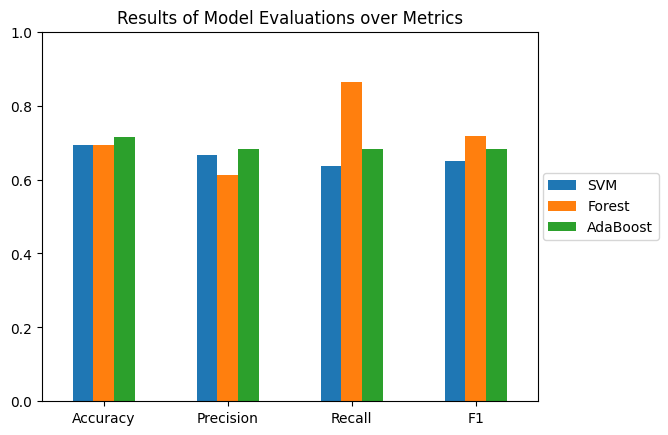

In [20]:
# Plotting results by metric

EvaluationsResults = pd.DataFrame(evaluation_results)
EvaluationsResults.rename(index={0:'Accuracy',1:'Precision',2:'Recall',3:'F1'},inplace=True)

fig , axes = plt.subplots()
axes.set_title('Results of Model Evaluations over Metrics')
EvaluationsResults.plot(kind='bar',rot=0,ax=axes,legend=False)
axes.set_ylim(0,1)
fig.legend(bbox_to_anchor=(1.1,0.6));

In [21]:
# Tabular results

EvaluationsResults

,SVM,Forest,AdaBoost
Accuracy,0.693878,0.693878,0.714286
Precision,0.666667,0.612903,0.681818
Recall,0.636364,0.863636,0.681818
F1,0.651163,0.716981,0.681818


# References

* [1] API Reference. Scikit-learn developers. https://scikit-learn.org/stable/api/index.html